In order to keep plots for each set of data, copy this notebook for each set of data

In [1]:
import warnings
#to suppress seaborn palette warnings
warnings.filterwarnings("ignore", category=UserWarning)
#to suppress seaborn error estimation NaN warnings
warnings.filterwarnings("ignore", category=RuntimeWarning)



import os

import numpy as np
import pandas as pd
import scipy
from scipy.stats import ttest_ind
import itertools

import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from matplotlib.patches import Rectangle

from loader import *
from analysis_functions import *

#to suppress pandas reassignment false positive warnings
pd.options.mode.chained_assignment = None  # default='warn'

### 1. Set Parameters

In [2]:
# directory files are pulled from
csv_directory = 'C:\\Users\\swind\\Documents\\lab_work\\Barth\\behavior_analysis\\Eunsol_data\\all_animals'
# directory to write output to (not implemented)
analysis_directory = 'C:\\Users\\swind\\Documents\\lab_work\\Barth\\behavior_analysis\\Eunsol_data\\refactor_4h'
# file containing information about animals (cage, age, sex, strain) - must have Animal ID column
metadata_file = 'C:\\Users\\swind\\Documents\\lab_work\\Barth\\behavior_analysis\\Eunsol_data\\eunsol_metadata.xlsx'

condition_name = 'SAT'
# animal_name = ''

acc_col_name = 'acc'
default_acc_time = 2 # days
time_bin = 240 # minutes

# using rolling window
freq_window = 300 # milliseconds
freq_bin = 100 # milliseconds

last_percent = 20
min_trials = 0
min_water_trials = 0
min_blank_trials = 0

### 2. Load Files

Directory Structure:

> ```
> all_conditions\
> |--- condition_1\
>      |--- animal_1\
>           |--- temptest.txtmm_dd_yy_T_HH_MM_SS.txt
>      |--- animal_2\
>      |--- etc.
> |--- condition_2\
>      |--- animal_1\
>      |--- animal_2\
>      |--- etc.
> |--- condition_3\
> |--- etc.
> ```

In [3]:
metadata = pd.read_excel(metadata_file)

#### Run one of the three following cells based on total data available (comment out the other two)

In [4]:
# this will load all conditions in a directory of multiple conditions
df = []
for d in os.listdir(csv_directory):
    cond = make_condition_df(csv_directory +'\\' + d, d, metadata, acc_col_name, default_acc_time)
    df.append(cond)
df = pd.concat(df)

NKZ4: no metadata
NLB1: no metadata


In [ ]:
# this will load one condition
# df = loader.make_condition_df(csv_directory, condition_name, metadata, acc_col_name, default_acc_time)

In [ ]:
# this will load one animal
# df = loader.make_animal_df(csv_directory, metadata, animal_name, acc_col_name, default_acc_time)
# df["condition"] = condition_name

### 3. Lick Frequency Analysys

In [5]:
data = lickfreq_analysis(df, freq_window, freq_bin, time_bin)

### 4. Bout Analysis

2 min bout length based on visual investigation of raster plots of 
individual animals trial distributions

In [6]:
data = get_bouts(data, ["animal"], "timestamp", "bout no", 2, "min")

### Previous trial identity

Uses bouts to only look at previous trials within a certain time frame. 
Only look at 5 previous trials since bouts are on average 5 trials long

In [7]:
trial_ind = ["animal", "trial no"]
bout_ind = ["animal", "bout no"]
key = "stimulus"
n = 5
cond0 = "stimulus"
cond1 = "blank"
data = get_n_back(data, trial_ind, bout_ind, key, n, cond0, cond1)

In [8]:
prev_stim = data[data["1_back"] == "stimulus"]
prev_blank = data[data["1_back"] == "blank"]

#### 5. Aggregate values

In [9]:
# temporary

data = data[data["condition"] != "dcz_05"]
data["type"] = ((data["condition"] == "SAT") | (data["condition"] == "all_reward")).replace({True:"sat", False:"hm4di"})

In [10]:
# all trials
mean_statistics, counts, perf = aggregate_analysis(data, min_trials, min_blank_trials, min_water_trials)
mean_statistics["n_back"] = 0
counts["n_back"] = 0
perf["n_back"] = 0

mean_statistics["back_type"] = "none"
counts["back_type"] = "none"
perf["back_type"] = "none"

In [ ]:
# only trials with n number of previous stimulus or blank
# doesn't work as intended (only if nth previous trial was stimulus or blank)
for i in range(1, n+1):
    cname = f'{i}_back'
    prev_stim = data[data[cname] == "stimulus"]
    
    prev_blank = data[data[cname] == "blank"]

    ps_mean, ps_totals, ps_perf = aggregate_analysis(prev_stim, min_trials, min_blank_trials, min_water_trials)
    ps_mean["n_back"] = i
    ps_counts["n_back"] = i 
    ps_perf["n_back"] = i
    ps_mean["back_type"] = "stimulus"
    ps_counts["back_type"] = "stimulus"
    ps_perf["back_type"] = "stimulus"

    pb_mean, pb_counts, pb_perf = aggregate_analysis(prev_blank, min_trials, min_blank_trials, min_water_trials)
    pb_mean["n_back"] = i
    pb_counts["n_back"] = i
    pb_perf["n_back"] = i
    pb_mean["back_type"] = "blank"
    pb_counts["back_type"] = "blank"
    pb_perf["back_type"] = "blank"

    mean_statistics = pd.concat([mean_statistics, ps_mean, pb_mean])
    counts = pd.concat([counts, ps_counts, pb_counts])
    perf = pd.concat([perf, ps_perf, pb_perf])


In [ ]:
keep = data.groupby(["animal", "bout no"]).last()[["condition", "age", "sex", "strain", "cage", "Time (hr)", "stimulus"]]
bout_start = data.groupby(["animal", "bout no"]).first()["timestamp"] 
bout_end = data.groupby(["animal", "bout no"]).last()["timestamp"]
bout_end_identity = data.groupby(["animal", "bout no"]).last()[["timestamp","stimulus"]]
bout_len = (bout_end - bout_start).rename("bout len")

intra_bt_trial_start = data.groupby(["animal", "bout no", "trial no"]).first()["timestamp"]
intra_bt_iti = (intra_bt_trial_start - intra_bt_trial_start.groupby(["animal", "bout no"]).shift()).fillna(pd.to_timedelta(0)).rename("intra bout iti")
intra_bt_iti = intra_bt_iti.groupby(["animal", "bout no"]).mean()

num_trials = intra_bt_trial_start.groupby(["animal", "bout no"]).count().rename("num trials")


ibi = (bout_start - bout_end.groupby(["animal"]).shift()).rename("ibi").fillna(0)
bout_stats = pd.concat([keep, bout_len, ibi, intra_bt_iti, num_trials], axis=1).reset_index()

bout_stats["bout len"] = bout_stats["bout len"].to_numpy(dtype="timedelta64[ms]").astype("float")/(1000.*60.)
bout_stats["ibi"] = bout_stats["ibi"].to_numpy(dtype="timedelta64[m]").astype("float")/60.
bout_stats["intra bout iti"] = bout_stats["intra bout iti"].to_numpy(dtype="timedelta64[ms]").astype("float")/1000.
bout_stats["frequency"] = bout_stats["num trials"]/bout_stats["bout len"]
bout_stats = bout_stats[bout_stats["condition"] != "dcz_05"]

bout_stats["cond_type"] = ((bout_stats["condition"] == "SAT") | (bout_stats["condition"] == "all_reward")).replace({True:"SAT", False:"cno"})

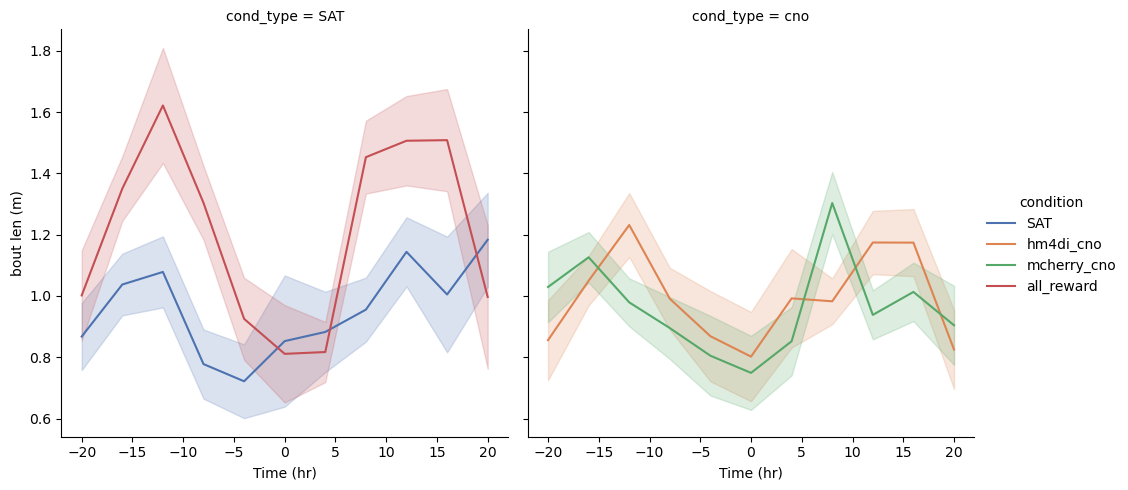

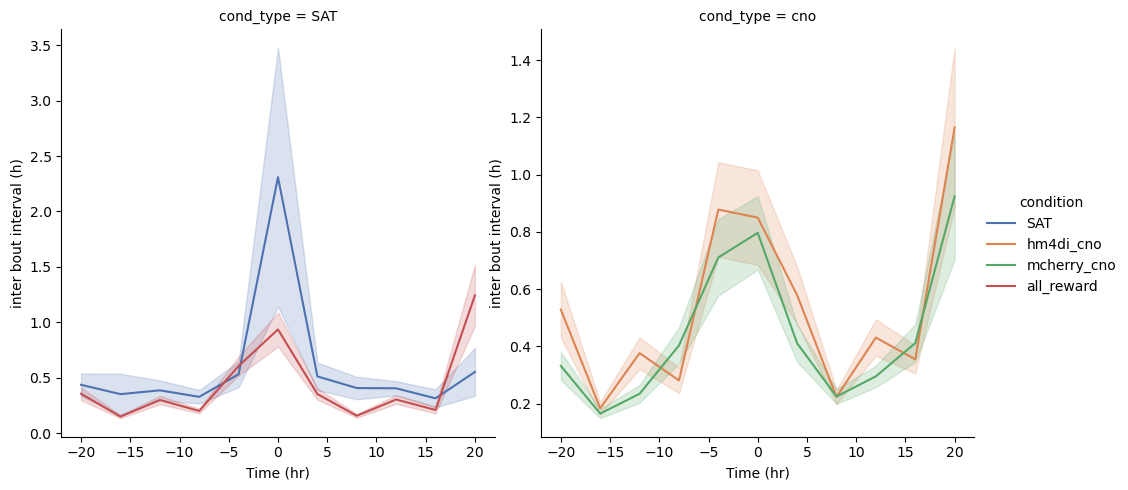

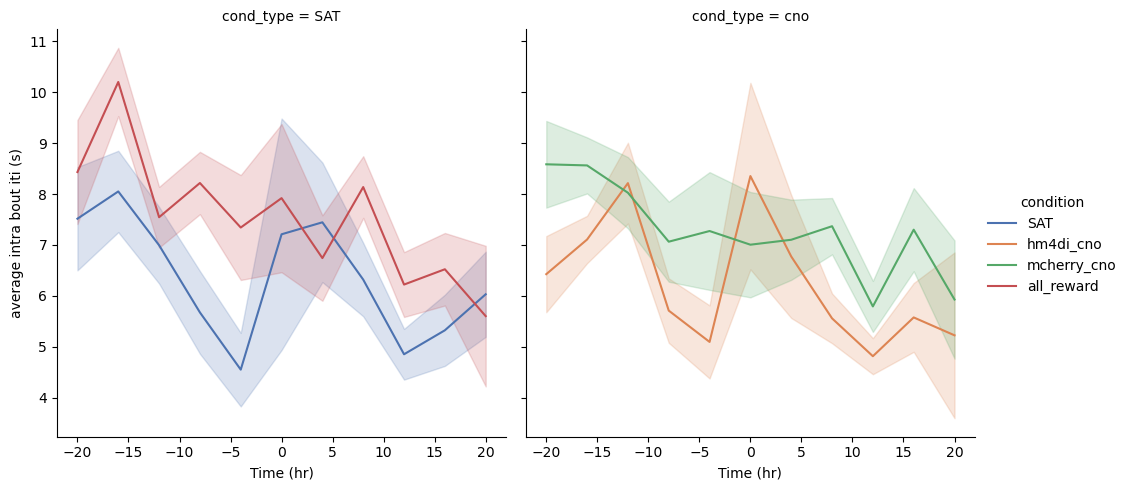

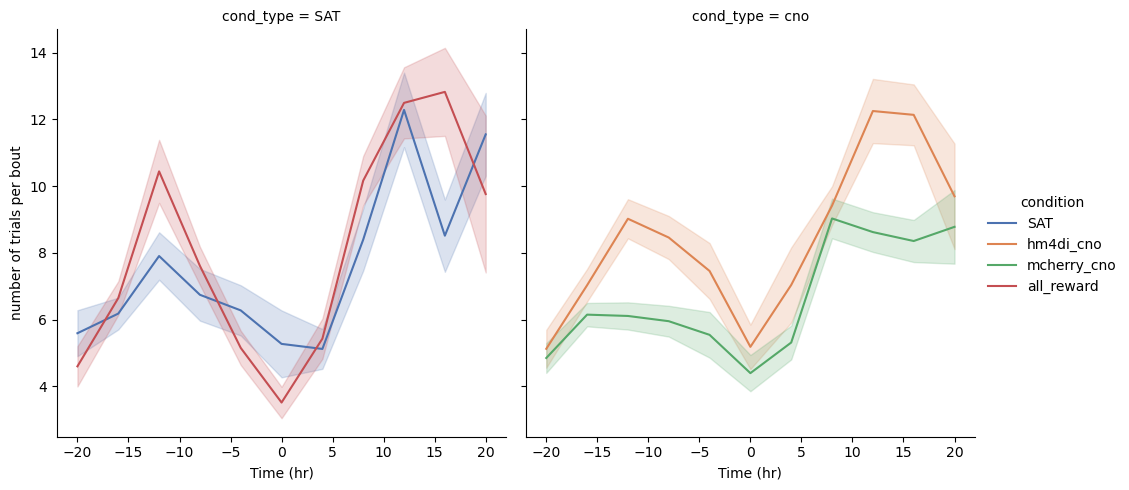

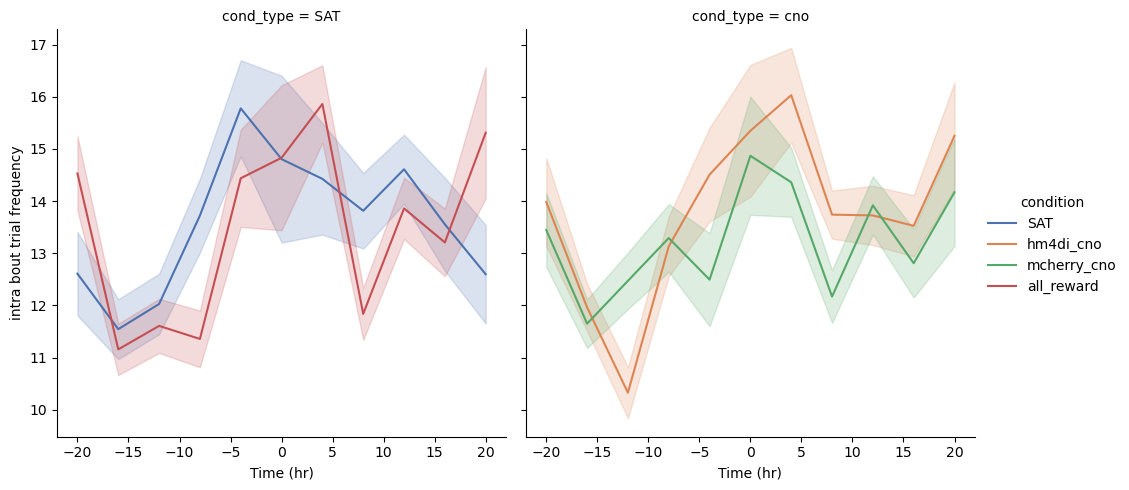

In [ ]:
cond = (bout_stats["Time (hr)"] > -24) & (bout_stats["Time (hr)"] < 24)
g = sns.relplot(bout_stats[cond], x="Time (hr)", y="bout len", hue="condition", col="cond_type", kind="line", errorbar="se", palette="deep")
g.set(ylabel="bout len (m)")

#cond = (bout_stats["Time (hr)"] > -48) & (bout_stats["Time (hr)"] < 24)
g = sns.relplot(bout_stats[cond], x="Time (hr)", y="ibi", hue="condition", kind="line", col="cond_type", errorbar="se", palette="deep", facet_kws={"sharey":False})
g.set(ylabel="inter bout interval (h)")

#cond = (bout_stats["Time (hr)"] > -48) & (bout_stats["Time (hr)"] < 24)
g = sns.relplot(bout_stats[cond], x="Time (hr)", y="intra bout iti", hue="condition", kind="line", col="cond_type", errorbar="se", palette="deep")
g.set(ylabel="average intra bout iti (s)")

#cond = (bout_stats["Time (hr)"] > -48) & (bout_stats["Time (hr)"] < 24)
g = sns.relplot(bout_stats[cond], x="Time (hr)", y="num trials", hue="condition", kind="line", col="cond_type", errorbar="se", palette="deep")
g.set(ylabel="number of trials per bout")

g = sns.relplot(bout_stats[cond], x="Time (hr)", y="frequency", hue="condition", kind="line", col="cond_type", errorbar="se", palette="deep")
g.set(ylabel="intra bout trial frequency")

### 6. Plots

In [ ]:
%matplotlib inline

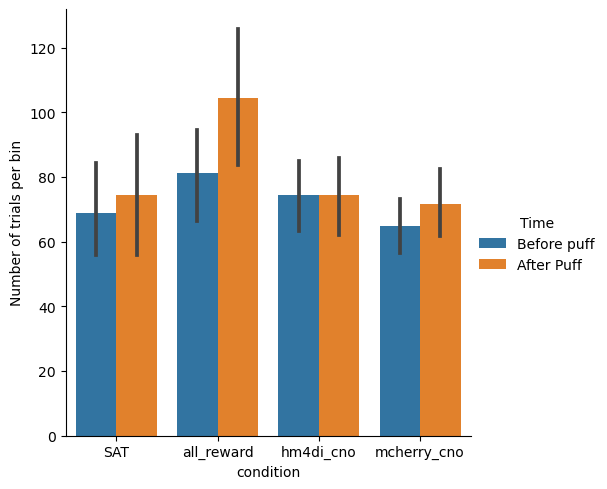

In [ ]:
# number of trials per 4h bin sat vs acc
total_trials = counts[counts["n_back"] == 0]
total_trials = total_trials.groupby(["condition", "animal", "Time (hr)"])["trial no"].sum().reset_index()

num_trials_acc = total_trials[total_trials["Time (hr)"] < 0]#.groupby(["condition"])["trial no"].mean().reset_index()
num_trials_acc["Time"] = "Before puff"
num_trials_sat = total_trials[total_trials["Time (hr)"] >= 0]#.groupby(["condition"])["trial no"].mean().reset_index()
num_trials_sat["Time"] = "After Puff"
num_trials = pd.concat([num_trials_acc, num_trials_sat])
num_trials = num_trials[num_trials["condition"] != "dcz_05"]
g = sns.catplot(num_trials, kind="bar", y="trial no", x="condition", hue="Time")
g.set_ylabels("Number of trials per bin")
num_trials.to_clipboard()

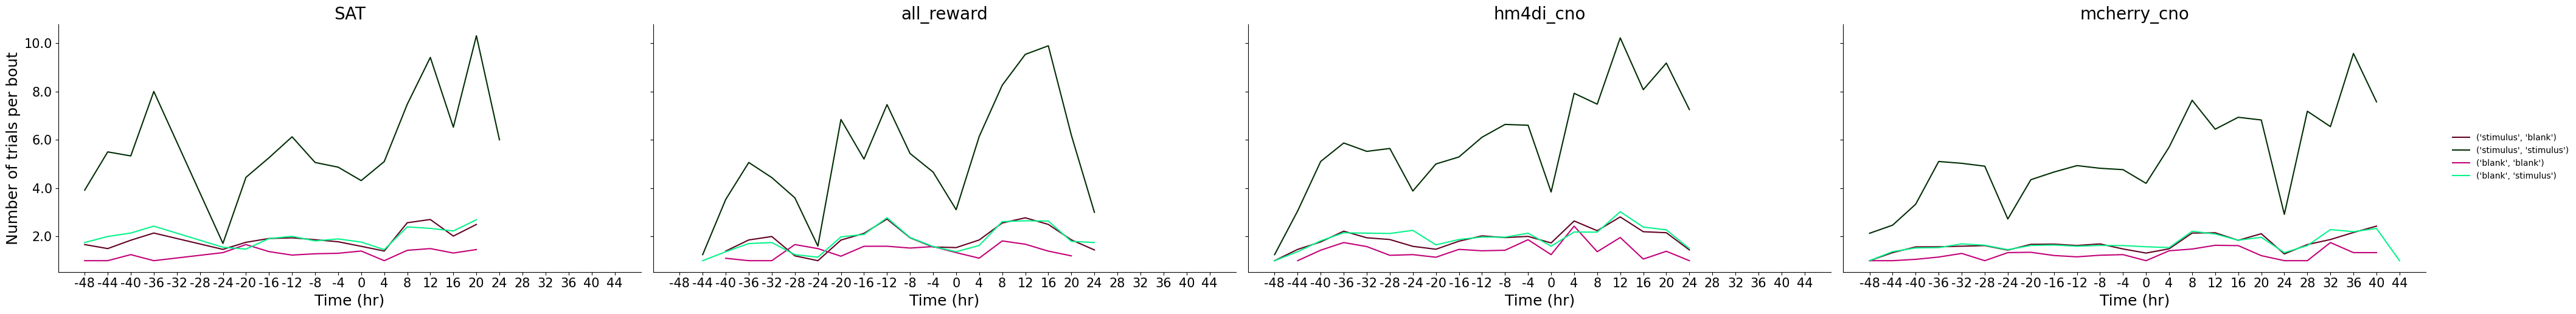

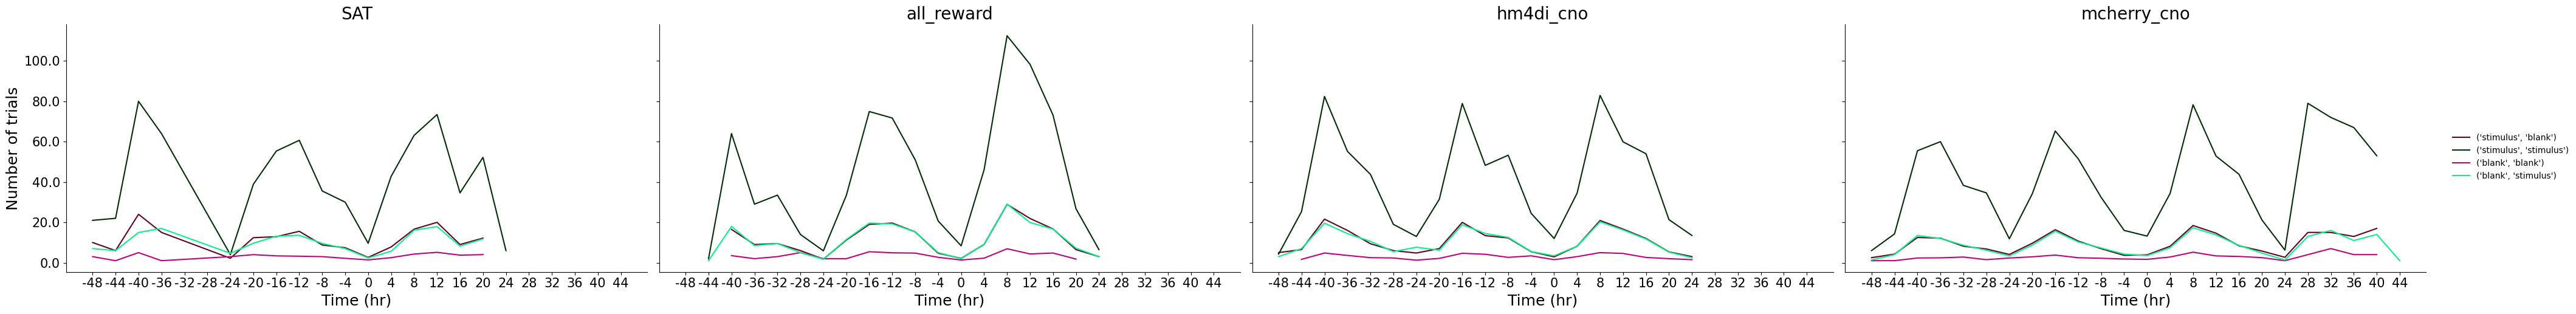

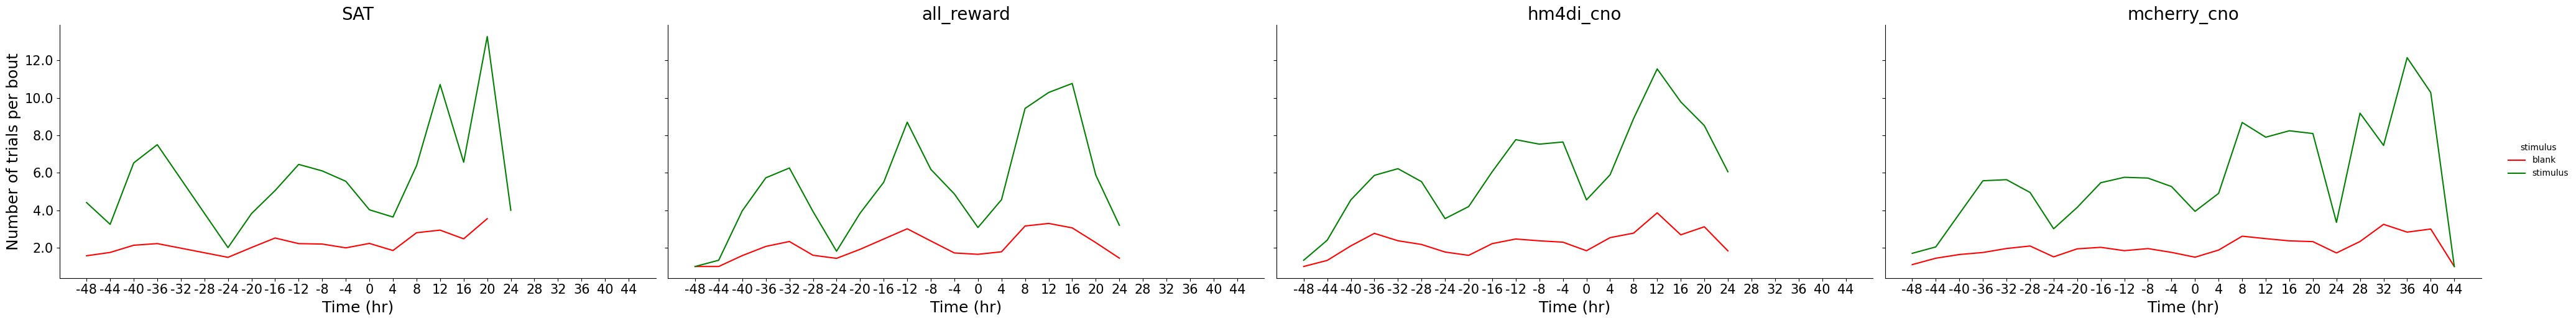

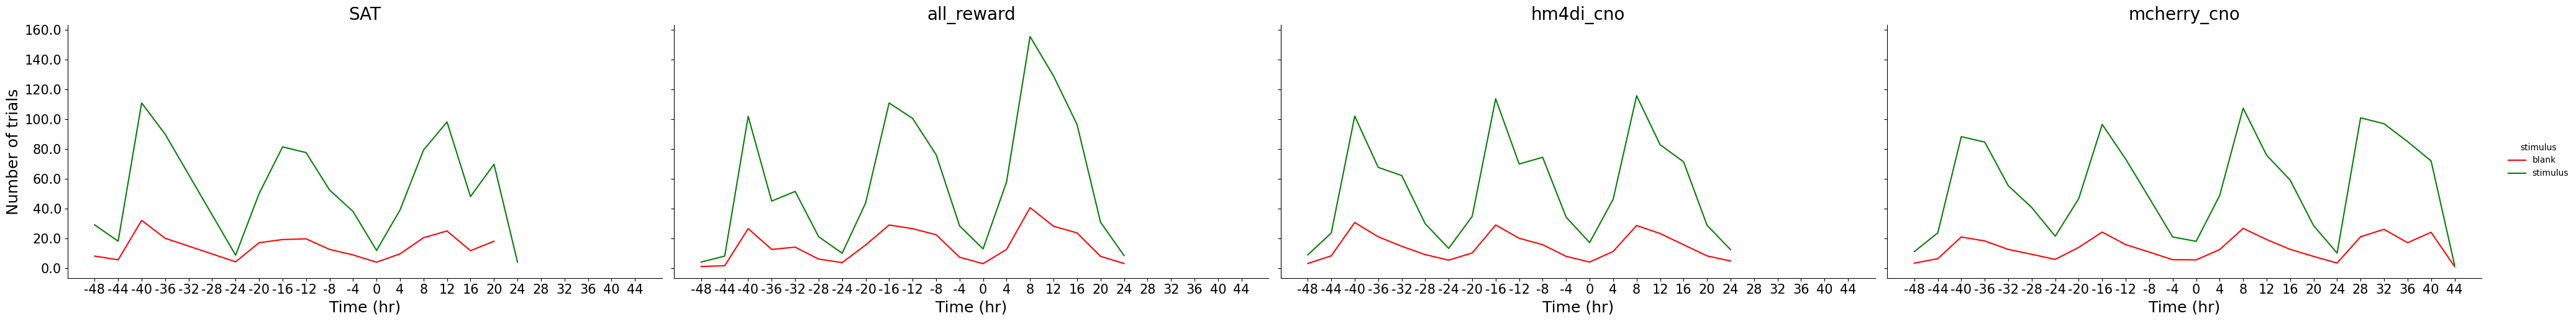

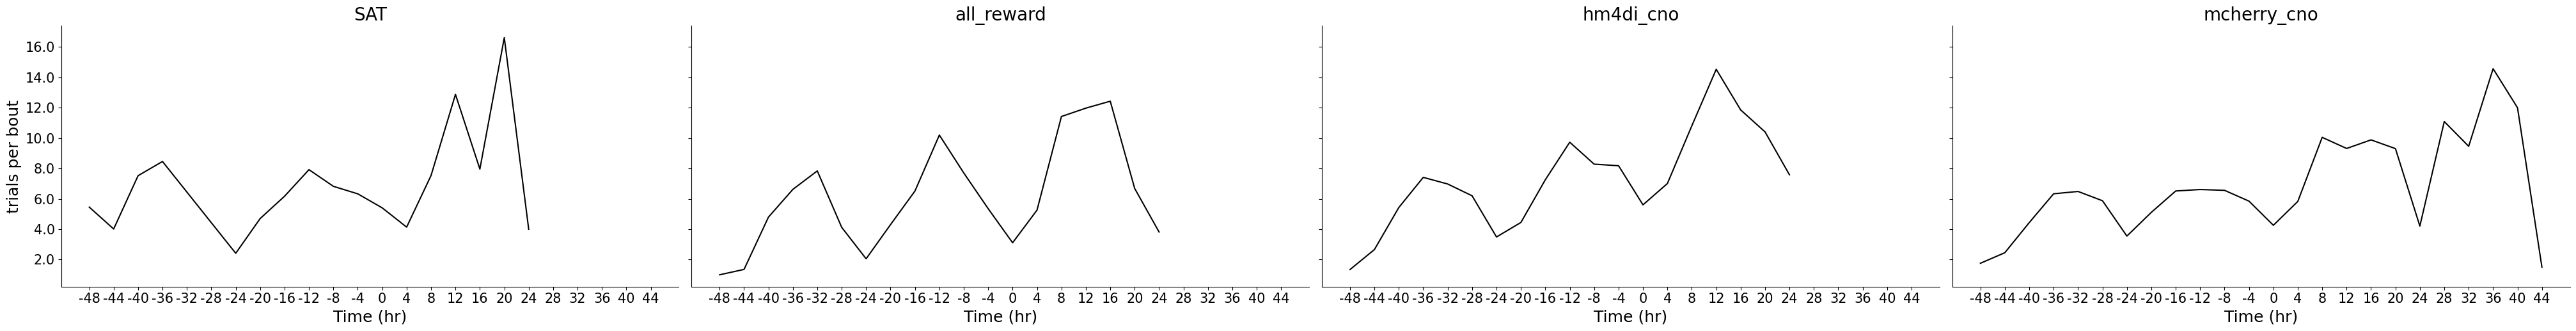

In [ ]:
# number of trials per bout over time by trial type and previous trial contingency
f = data.groupby(["condition", "animal", "Time (hr)", "bout no", "trial no"]).first().reset_index()
f = f[f["condition"] != "dcz_05"]
counts_prev = f.groupby(["condition","animal", "Time (hr)", "bout no", "stimulus", "1_back"]).count()
cts_gp = counts_prev.groupby(["condition", "animal", "Time (hr)", "stimulus", "1_back"])
mean_prev = cts_gp.mean().reset_index()
total_prev = cts_gp.sum().reset_index()

counts_stim = f.groupby(["condition","animal", "Time (hr)", "bout no", "stimulus"]).count()
cts_gp = counts_stim.groupby(["condition", "animal", "Time (hr)", "stimulus"])
mean_stim = cts_gp.mean().reset_index()
total_stim = cts_gp.sum().reset_index()

counts_all = f.groupby(["condition","animal", "Time (hr)", "bout no"]).count()
mean_all = counts_all.groupby(["condition", "animal", "Time (hr)"]).mean().reset_index()

h = mean_prev[['1_back', 'stimulus']].apply(tuple, axis=1)
p = ["xkcd:burgundy", "xkcd:dark forest green", "xkcd:magenta", "xkcd:turquoise green"]
ordr = [('stimulus', 'blank'),
       ('stimulus', 'stimulus'), ('blank', 'blank'),
       ('blank', 'stimulus')]
       
g = sns.relplot(data=mean_prev, x="Time (hr)", y="lick", col="condition", hue=h, 
                palette=p, hue_order=ordr, kind="line", errorbar=None, aspect=2)
ticks = [i for i in range(-48, 48, 4)]
for (col_val), ax in g.axes_dict.items():
    ax.set_title(f'{col_val}', fontsize=20)
    ax.set_xlabel("Time (hr)", fontsize=18)
    ax.set_ylabel("Number of trials per bout", fontsize=18)
    ax.set_xticks(ticks)
    ax.set_xticklabels(ticks, ha='center', fontsize=15)
    ax.set_yticklabels(ax.get_yticks(), fontsize=15)

g = sns.relplot(data=total_prev, x="Time (hr)", y="lick", col="condition", hue=h, 
                palette=p, hue_order=ordr,kind="line", errorbar=None, aspect=2)
ticks = [i for i in range(-48, 48, 4)]
for (col_val), ax in g.axes_dict.items():
    ax.set_title(f'{col_val}', fontsize=20)
    ax.set_xlabel("Time (hr)", fontsize=18)
    ax.set_ylabel("Number of trials", fontsize=18)
    ax.set_xticks(ticks)
    ax.set_xticklabels(ticks, ha='center', fontsize=15)
    ax.set_yticklabels(ax.get_yticks(), fontsize=15)

g = sns.relplot(data=mean_stim, x="Time (hr)", y="lick", col="condition", 
                hue="stimulus", palette=["red", "green"], hue_order=["blank", 'stimulus'], 
                kind="line", errorbar=None, aspect=2)
ticks = [i for i in range(-48, 48, 4)]
for (col_val), ax in g.axes_dict.items():
    ax.set_title(f'{col_val}', fontsize=20)
    ax.set_xlabel("Time (hr)", fontsize=18)
    ax.set_ylabel("Number of trials per bout", fontsize=18)
    ax.set_xticks(ticks)
    ax.set_xticklabels(ticks, ha='center', fontsize=15)
    ax.set_yticklabels(ax.get_yticks(), fontsize=15)

g = sns.relplot(data=total_stim, x="Time (hr)", y="lick", col="condition", 
                hue="stimulus", palette=["red", "green"], hue_order=["blank", 'stimulus'], 
                kind="line", errorbar=None, aspect=2)
ticks = [i for i in range(-48, 48, 4)]
for (col_val), ax in g.axes_dict.items():
    ax.set_title(f'{col_val}', fontsize=20)
    ax.set_xlabel("Time (hr)", fontsize=18)
    ax.set_ylabel("Number of trials", fontsize=18)
    ax.set_xticks(ticks)
    ax.set_xticklabels(ticks, ha='center', fontsize=15)
    ax.set_yticklabels(ax.get_yticks(), fontsize=15)

g = sns.relplot(data=mean_all, x="Time (hr)", y="lick", col="condition", color='k', kind="line", errorbar=None, aspect=2)
ticks = [i for i in range(-48, 48, 4)]
for (col_val), ax in g.axes_dict.items():
    ax.set_title(f'{col_val}', fontsize=20)
    ax.set_xlabel("Time (hr)", fontsize=18)
    ax.set_ylabel("Number of trials", fontsize=18)
    ax.set_xticks(ticks)
    ax.set_xticklabels(ticks, ha='center', fontsize=15)
    ax.set_yticklabels(ax.get_yticks(), fontsize=15)

g.set(ylabel="trials per bout")    

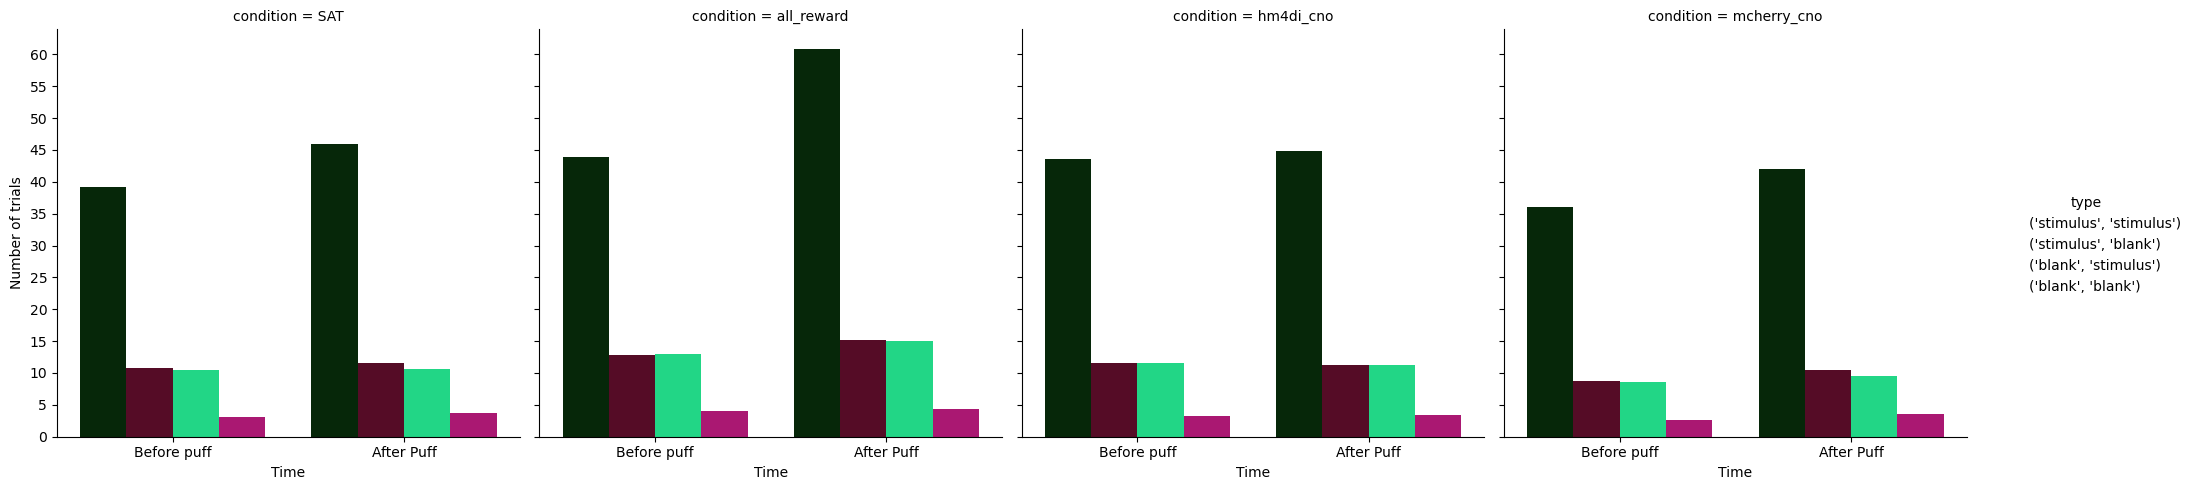

In [ ]:
# number of trials in a bin by previous trial contingency acc vs sat
num_trials_acc = total_prev[total_prev["Time (hr)"] < 0].groupby(["condition", "1_back", "stimulus"])["lick"].mean().reset_index()
num_trials_acc["Time"] = "Before puff"
num_trials_sat = total_prev[total_prev["Time (hr)"] >= 0].groupby(["condition", "1_back", "stimulus"])["lick"].mean().reset_index()
num_trials_sat["Time"] = "After Puff"
num_trials = pd.concat([num_trials_acc, num_trials_sat])
h = num_trials[['1_back', 'stimulus']].apply(tuple, axis=1)
num_trials["type"] = h
p = ["xkcd:dark forest green", "xkcd:burgundy",  "xkcd:turquoise green", "xkcd:magenta"]
ordr = [('stimulus', 'stimulus'), ('stimulus', 'blank'),
       ('blank', 'stimulus'), ('blank', 'blank'),
       ]

ticks = mpl.ticker.MultipleLocator(5)
g = sns.catplot(num_trials, kind="bar", y="lick", x="Time", hue="type", palette=p, col="condition", hue_order=ordr)
g.set_ylabels("Number of trials")
for ax in g.axes.flat:
  ax.yaxis.set_major_locator(ticks)

In [ ]:
%matplotlib widget

(-0.5, 1.5)

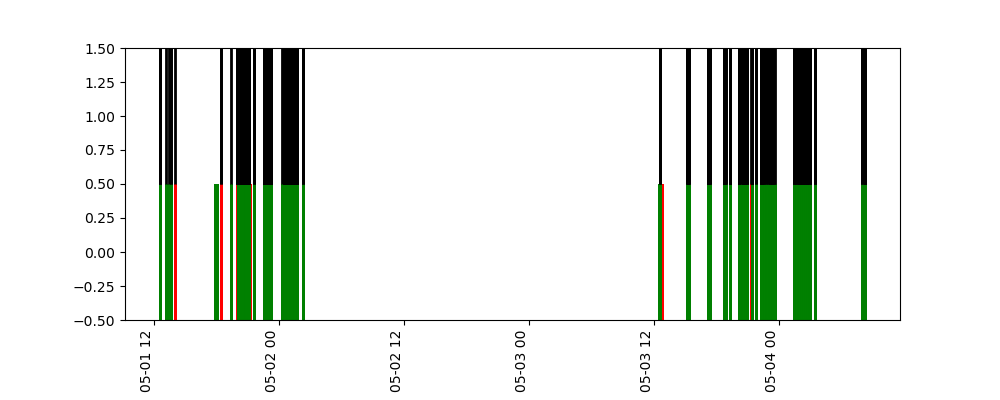

In [ ]:
# raster for one animal
gko6 = df[df["animal"] == "GKO6"]
gps = []
for gname, gp in gko6.groupby(["stimulus"]):
    gps.append(gp["timestamp"])



gps.append(gko6[gko6["poke2"] == 1]["timestamp"])
fig, ax = plt.subplots(1, 1, figsize=(10,4))
c = ["red", "green", "black"]

lo = [0,0,1]
lw = [2,2,2]
ll = 1
#ticks = mpl.ticker.MultipleLocator(base=1.0)
ax.eventplot(positions=gps, colors=c, lineoffsets=lo, linewidths=lw, linelengths=ll)
#ax.xaxis.set_major_locator(mpl.dates.MinuteLocator(interval=60))  
#ax.xaxis.set_minor_locator(mpl.dates.MinuteLocator(interval=5))  
fig.autofmt_xdate(rotation=90)
ax.set_ylim([-0.5,1.5])


In [ ]:
%matplotlib inline
plt.clf()

In [11]:
counts

condition animal             delta  stimulus     water  trial no  \
8              SAT   GKO6 -2 days +00:00:00     blank  no water         1   
9              SAT   GKO6 -2 days +00:00:00  stimulus     water         5   
60             SAT   GKO6 -2 days +04:00:00     blank  no water         3   
61             SAT   GKO6 -2 days +04:00:00  stimulus     water         3   
114            SAT   GKO6 -2 days +08:00:00     blank  no water        31   
...            ...    ...               ...       ...       ...       ...   
55305  mcherry_cno  NIO16   0 days 08:00:00  stimulus     water       106   
55386  mcherry_cno  NIO16   0 days 12:00:00     blank  no water        12   
55387  mcherry_cno  NIO16   0 days 12:00:00  stimulus     water        33   
55462  mcherry_cno  NIO16   0 days 16:00:00     blank  no water         4   
55463  mcherry_cno  NIO16   0 days 16:00:00  stimulus     water        23   

        age sex        strain    acc     cage  Time (hr)  n_back back_type  
8      31.0   M  Sscre x Ai32 2 days    Mason      -48.0       0      none  
9      31.0   M  Sscre x Ai32 2 days    Mason      -48.0       0      none  
60     31.0   M  Sscre x Ai32 2 days    Mason      -44.0       0      none  
61     31.0   M  Sscre x Ai32 2 days    Mason      -44.0       0      none  
114    31.0   M  Sscre x Ai32 2 days    Mason      -40.0       0      none  
...     ...  ..           ...    ...      ...        ...     ...       ...  
55305  26.0   M        SSTcre 1 days  Chicago        8.0       0      none  
55386  26.0   M        SSTcre 1 days  Chicago       12.0       0      none  
55387  26.0   M        SSTcre 1 days  Chicago       12.0       0      none  
55462  26.0   M        SSTcre 1 days  Chicago       16.0       0      none  
55463  26.0   M        SSTcre 1 days  Chicago       16.0       0      none  

[1224 rows x 14 columns]

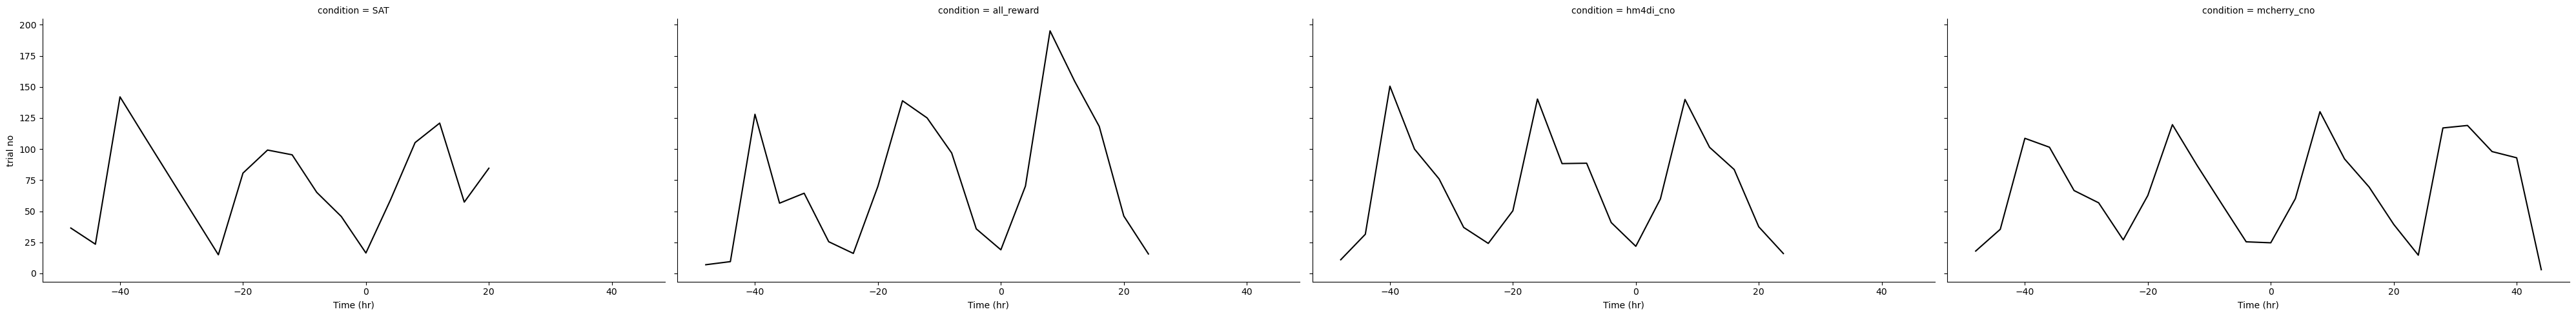

In [ ]:
# number of trials over time

cond = total_trials["condition"] != "dcz_05"
sns.relplot(data=total_trials[cond], x="Time (hr)", y="trial no", kind="line", color='k', col="condition", errorbar=None, aspect=2)

In [85]:
def style_plot(fig):
    for (row_val, col_val), ax in fig.axes_dict.items():
        t = f'{row_val} at {col_val} hr'
        ax.set_title(t, fontsize=22)
        #ax.axvline(x=0, ymin=0, ymax=1, ls="--", color="lightgrey", zorder=0)
        ymin, ymax = ax.get_ylim()
        xmin, xmax = ax.get_xlim()
        ax.add_patch(Rectangle((0, -6),500, 12, color="grey", alpha=0.5, zorder=0, fill=True))
        ax.axvline(x=1000, ymin=0, ymax=1, ls="-", color="navy", alpha=0.5, zorder=0)
        ax.set_ylim([-6, 6])

        ax.set_ylabel("Lick Freq (hz)", fontsize=20)
        ax.set_xlabel("Time (ms)", fontsize=20)
        ax.xaxis.set_major_locator(ticker.MultipleLocator(200))  

        ax.set_xticklabels(ax.get_xticklabels(), fontsize=18)
        ax.set_yticklabels(ax.get_yticklabels(), fontsize=18)

    g.figure.subplots_adjust(hspace=0.35, wspace=0.15)
    sns.move_legend(g, "center right", bbox_to_anchor=(1.02,0.5))
    plt.setp(g._legend.get_title(), fontsize='25')
    plt.setp(g._legend.get_texts(), fontsize='20')


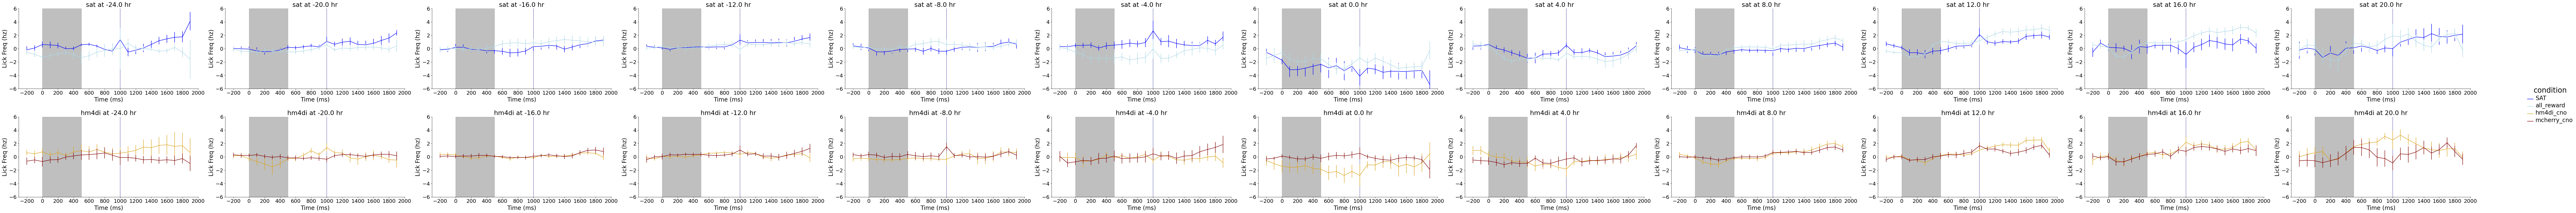

In [86]:
# performance across trial (all timebins in one plot)
perf["type"] = ((perf["condition"] == "SAT") | (perf["condition"] == "all_reward")).replace({True:"sat", False:"hm4di"})
cond = ( (perf["Time (hr)"] < 24) & (perf["Time (hr)"] >= -24) 
       & (perf["n_back"] == 0) & (perf["condition"] != "dcz_05"))

g = sns.relplot(data=perf[cond], kind="line",x="Time (ms)", y="lick",col="Time (hr)", 
                row="type", hue="condition", palette=["blue", "lightblue", "goldenrod", "maroon"],errorbar="se",err_style="bars", legend="brief", aspect=2,
                facet_kws={"sharex":False, "sharey":False} )

# add lines at air puff and water delivery
style_plot(g)

[None, None, None, None]

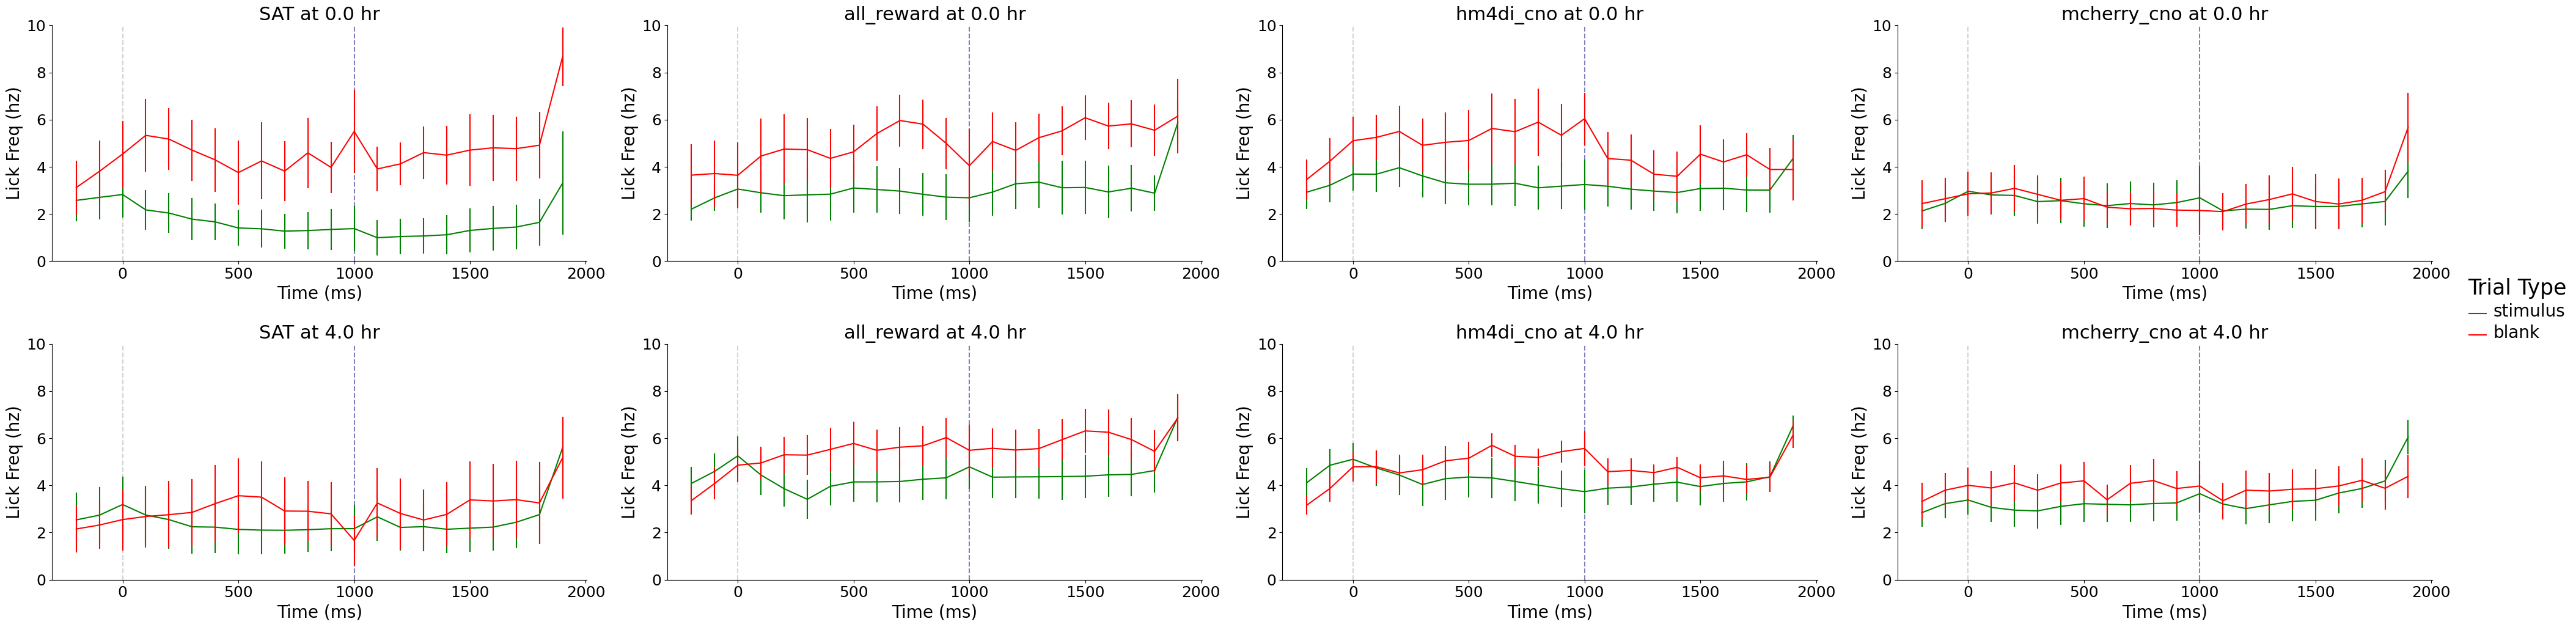

In [ ]:
#  across trial lick frequency
cond = (mean_statistics["Time (hr)"] >= 0) & (mean_statistics["Time (hr)"] < 8) & (mean_statistics["n_back"] == 0)
# plot all timebins average performance trace on the same plot
g = sns.relplot(data=mean_statistics[cond],kind="line",x="Time (ms)", y="lick",
                col="condition", row="Time (hr)", hue="stimulus", 
                palette=["green", "red"], hue_order=["stimulus", "blank"], 
                errorbar="se",err_style="bars", legend="full", aspect=2, 
                facet_kws={"sharex":False, "sharey":False})


# add lines at air puff and water delivery
for (row_val, col_val), ax in g.axes_dict.items():
    t = f'{col_val} at {row_val} hr'
    ax.set_title(t, fontsize=22)

    ax.axhline(y=0, xmin=0, xmax=1, ls="-", lw=0.75,color="black", zorder=0)
    ax.axvline(x=0, ymin=0, ymax=1, ls="--", color="lightgrey", zorder=0)
    ax.axvline(x=1000, ymin=0, ymax=1, ls="--", color="navy", alpha=0.5, zorder=0)
    ax.set_ylim([0, 10])
    ax.set_ylabel("Lick Freq (hz)", fontsize=20)
    ax.set_xlabel("Time (ms)", fontsize=20)
    ax.set_xticklabels(ax.get_xticklabels(), fontsize=18)
    ax.set_yticklabels(ax.get_yticklabels(), fontsize=18)

g.figure.subplots_adjust(hspace=0.35, wspace=0.15)
g._legend.set_title("Trial Type")
sns.move_legend(g, "center right", bbox_to_anchor=(1.02,0.5))
plt.setp(g._legend.get_title(), fontsize='25')
plt.setp(g._legend.get_texts(), fontsize='20')




In [ ]:
# across trial lick frequency previous trial contingency

p = ["xkcd:light pink", "xkcd:greyish", "xkcd:burgundy", "xkcd:dark forest green", "xkcd:magenta", "xkcd:turquoise green"]
ordr = [('none', 'blank'), ('none', 'stimulus'), ('stimulus', 'blank'),
       ('stimulus', 'stimulus'), ('blank', 'blank'),
       ('blank', 'stimulus')]

cond_dict = {"SAT":"SAT", "all_reward":"100% acclimation, 80% SAT", "hm4di_cno":"hM4Di plus CNO", "mcherry_cno":"mCherry plus CNO"}
mean_statistics = mean_statistics[mean_statistics["condition"] != "dcz_05"]
# lick frequency
cond = ((mean_statistics["Time (hr)"] < 24) & (mean_statistics["Time (hr)"] >= 0) 
      & (mean_statistics["n_back"] < 2) )

for c in mean_statistics["condition"].unique():
    for stim_type in mean_statistics["stimulus"].unique():
        c2 = cond & (mean_statistics["condition"] == c) & (mean_statistics["stimulus"] == stim_type)
        h = mean_statistics[c2][['back_type', 'stimulus']].apply(tuple, axis=1)

        # plot all timebins average performance trace on the same plot
        g = sns.relplot(data=mean_statistics[c2],kind="line",x="Time (ms)",
                        y="lick", col="Time (hr)", row="back_type",
                        hue=h, palette=p, hue_order=ordr, aspect=2,
                        errorbar=None,facet_kws={"sharex":False})

        # add lines at air puff and water delivery
        #ticks = [i for i in range(-200, 2000, 200)]
        row_dict = {"none":"all trials", "stimulus":"trials preceded by stimulus", "blank":"trials preceded by blank"}
        for (row_val, col_val), ax in g.axes_dict.items():
            t = f'{row_dict[row_val]} at {col_val}'
            ax.set_title(t, fontsize=22)
            ax.axhline(y=0, xmin=0, xmax=1, ls="-", lw=0.75,color="black", zorder=0)
            ax.axvline(x=0, ymin=0, ymax=1, ls="--", color="lightgrey", zorder=0)
            ax.axvline(x=1000, ymin=0, ymax=1, ls="--", color="navy", alpha=0.5, zorder=0)
            ax.set_xticks(ticks)
            ax.set_xticklabels(ticks, ha='center')
            ax.set_ylim([0, 10])
            ax.set_ylabel("Lick Frequency (Hz)", fontsize=18)
            ax.set_xlabel("Time (ms)", fontsize=18)
        g.figure.subplots_adjust(hspace=0.3)
        g.fig.suptitle(f'{title_dict[c]} {stim_type} trials', fontsize=28, y=1.05, x=.47)



In [138]:
# from jsgounot on stackoverflow (https://stackoverflow.com/questions/34888058/changing-width-of-bars-created-with-catplot-or-barplot)
def change_width(ax, new_value) :
    for patch in ax.patches :
        current_width = patch.get_width()
        diff = current_width + new_value

        # we change the bar width
        patch.set_width(new_value)

        # we recenter the bar
        patch.set_x(patch.get_x() + diff * .5)


In [56]:
c.index

Index([21, 26, 22, 23, 24, 25, 15, 16, 20, 17, 18, 19, 10, 12, 11,  8,  9, 13,
       14,  7,  2,  0,  1,  3,  4,  5,  6],
      dtype='int64')

'a'

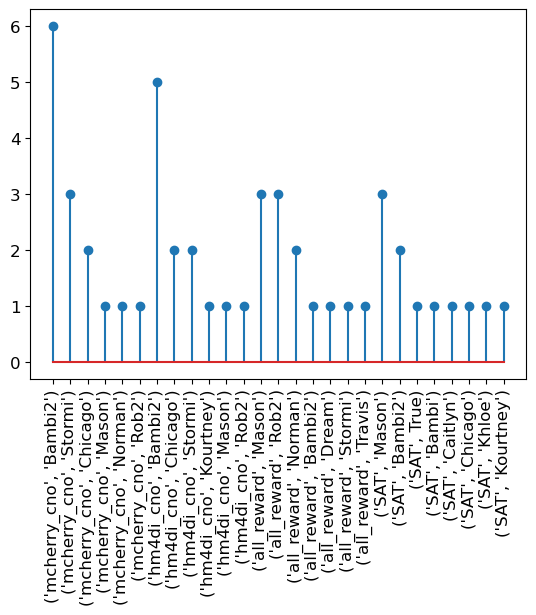

In [60]:
c = counts.groupby(["condition", "animal"]).first().groupby(["condition", "cage"]).count()["delta"].reset_index().sort_values(by=["condition","delta"],ascending=False).set_index(["condition", "cage"])
plt.stem(c['delta'])
my_range=range(0,len(c.index))
plt.xticks(my_range, c.index, rotation=90, ha="center")
'a'

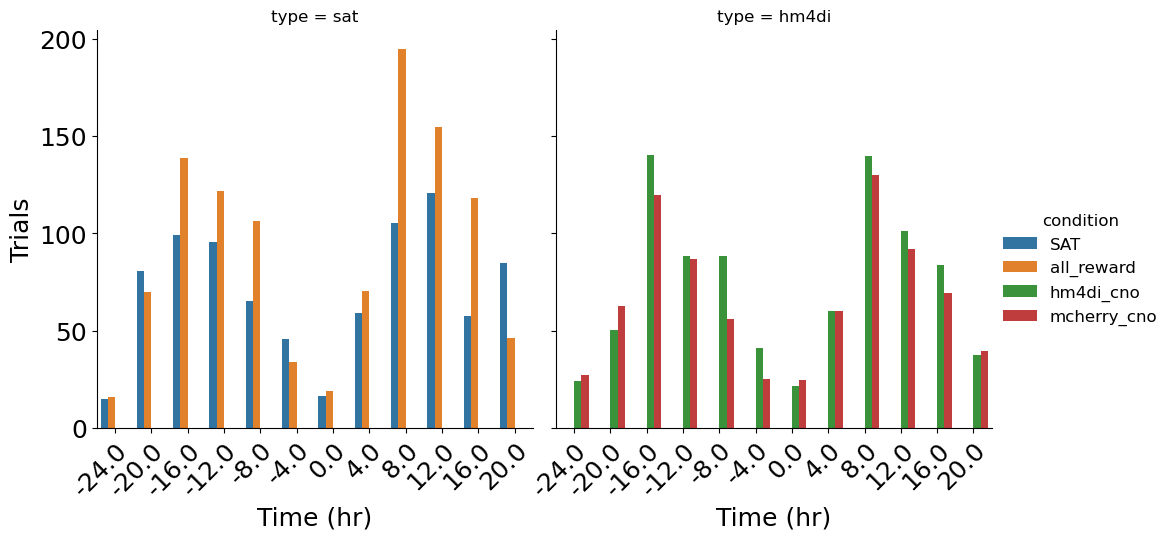

In [25]:
totals = counts.groupby(["condition", "animal", "cage", "Time (hr)"])["trial no"].sum().reset_index()
totals["type"] = ((totals["condition"] == "SAT") | (totals["condition"] == "all_reward")).replace({True:"sat", False:"hm4di"})

cond = (totals["Time (hr)"] < 24) & (totals["Time (hr)"] >= -24)# & (totals["cage"] != "Kourtney")
g = sns.catplot(totals[cond], x="Time (hr)", y="trial no",
                hue="condition", col ="type", 
                kind="bar", errorbar=None, dodge=True)

#cond_dict = {"SAT":"SAT", "all_reward":"100% acclimation, 80% SAT", "hm4di_cno":"hM4Di plus CNO", "mcherry_cno":"mCherry plus CNO"}

i=0
plt.rcParams["font.size"] = 12
for (col_val), ax in g.axes_dict.items():
    #t=f"{cond_dict[col_val]}"
    #ax.set_title(t, fontsize=22)
    ax.tick_params(labelbottom=True, labelsize=18)
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")
    ax.set_ylabel("Trials", fontsize=18)
    ax.set_xlabel("Time (hr)", fontsize=18)
    #for j in range(len(ax.containers)):
    #    ax.bar_label(ax.containers[j], fmt='%0.1f')
    i += 1
g.figure.subplots_adjust(hspace=0.3)

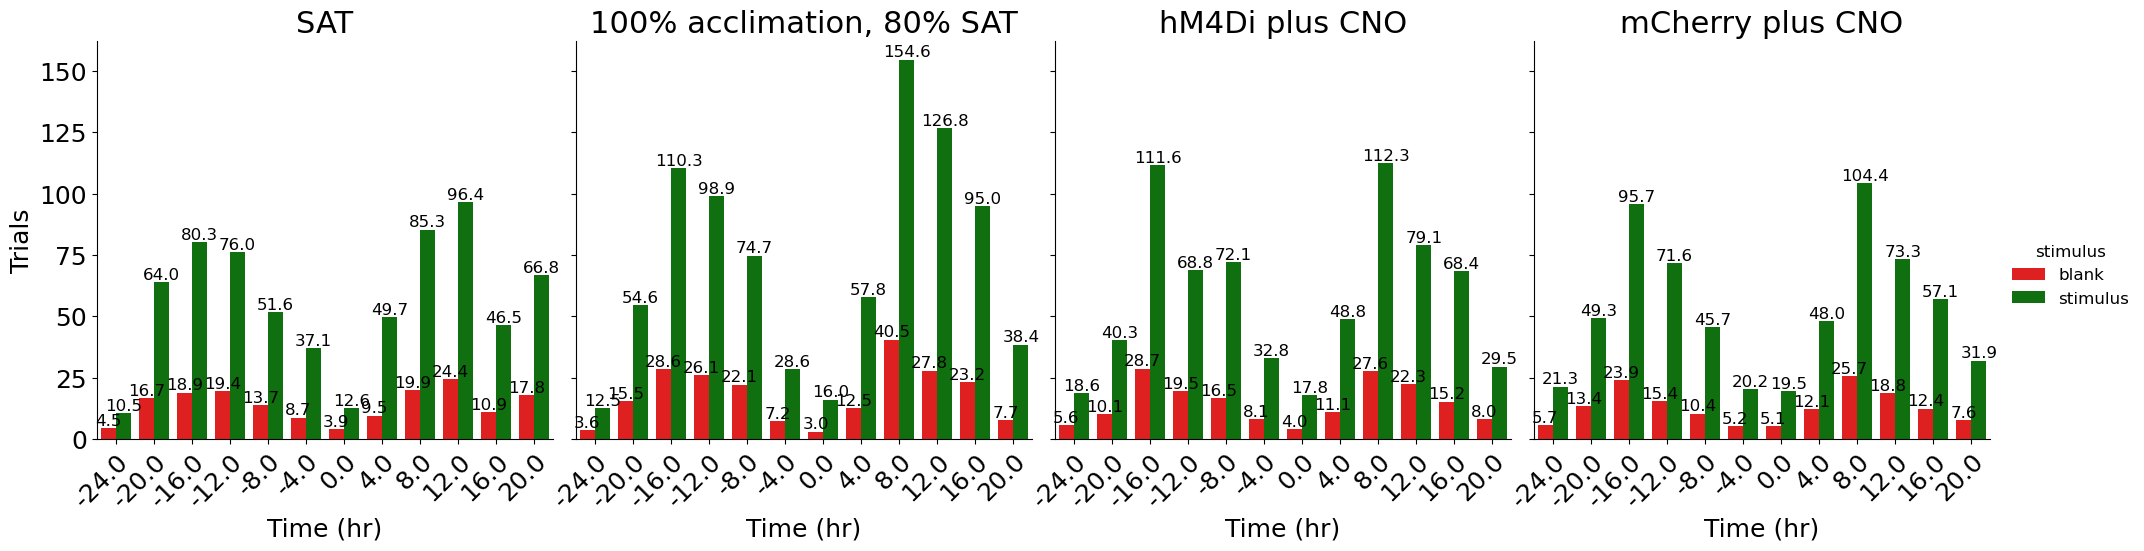

In [233]:
counts["type"] = ((counts["condition"] == "SAT") | (counts["condition"] == "all_reward")).replace({True:"sat", False:"hm4di"})

cond = (counts["Time (hr)"] < 24) & (counts["Time (hr)"] >= -24)
g = sns.catplot(counts[cond], x="Time (hr)", y="trial no",
                hue="stimulus", col ="condition", palette = ["red", "green"], 
                kind="bar", errorbar=None)

cond_dict = {"SAT":"SAT", "all_reward":"100% acclimation, 80% SAT", "hm4di_cno":"hM4Di plus CNO", "mcherry_cno":"mCherry plus CNO"}

i=0
plt.rcParams["font.size"] = 12
for (col_val), ax in g.axes_dict.items():
    t=f"{cond_dict[col_val]}"
    ax.set_title(t, fontsize=22)
    ax.tick_params(labelbottom=True, labelsize=18)
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")
    ax.set_ylabel("Trials", fontsize=18)
    ax.set_xlabel("Time (hr)", fontsize=18)
    new_value=0.4 
    for j in range(len(ax.containers)):
        ax.bar_label(ax.containers[j], fmt='%0.1f')
    i += 1
g.figure.subplots_adjust(hspace=0.3)

In [ ]:
satcond = (counts["condition"]=="SAT")
allcond = (counts["condition"]=="all_reward")
hcond = (counts["condition"]=="hm4di_cno")
mcond = (counts["condition"]=="mcherry_cno")

ttests_sat = []
ttests_hm4di = []
for i in range (-24, 24, 4):
    timecond = (counts["Time (hr)"] == i)
    for stim in ["blank", "stimulus"]:
        stimcond = (counts["stimulus"] == stim) & timecond
        test_sat = ttest_ind(counts[satcond & stimcond]["trial no"], counts[allcond & stimcond]["trial no"], equal_var=False)
        ttests_sat.append((test_sat.statistic, test_sat.pvalue))
        test_h = ttest_ind(counts[hcond & stimcond]["trial no"], counts[mcond & stimcond]["trial no"], equal_var=False)
        ttests_hm4di.append((test_h.statistic, test_h.pvalue))

indd = pd.MultiIndex.from_product([np.arange(-24, 24, 4), ["blank", "stimulus"]], names=["Time (hr)", "stimulus"])
ttests_sat = pd.DataFrame(ttests_sat).rename(columns={0:"statistic", 1:"pvalue"}).set_index(indd)
ttests_hm4di = pd.DataFrame(ttests_hm4di).rename(columns={0:"statistic", 1:"pvalue"}).set_index(indd)

In [260]:
ttests_hm4di[ttests_hm4di["pvalue"] < 0.05]

statistic    pvalue
Time (hr) stimulus                     
-8        blank      2.328963  0.032281
          stimulus   2.274837  0.038540
-4        stimulus   2.297597  0.031281

In [258]:
ttests_sat[ttests_sat["pvalue"] < 0.05]

statistic    pvalue
stimulus Time (hr)                     
8        blank      -4.093607  0.000751
         stimulus   -3.206183  0.005037

In [261]:
satcond = (totals["condition"]=="SAT")
allcond = (totals["condition"]=="all_reward")
hcond = (totals["condition"]=="hm4di_cno")
mcond = (totals["condition"]=="mcherry_cno")

ttests_sat = []
ttests_hm4di = []
for i in range (-24, 24, 4):
    timecond = (totals["Time (hr)"] == i)
    test_sat = ttest_ind(totals[satcond & timecond]["trial no"], totals[allcond & timecond]["trial no"], equal_var=False)
    ttests_sat.append((test_sat.statistic, test_sat.pvalue))
    test_h = ttest_ind(totals[hcond & timecond]["trial no"], totals[mcond & timecond]["trial no"], equal_var=False)
    ttests_hm4di.append((test_h.statistic, test_h.pvalue))

ttests_sat = pd.DataFrame(ttests_sat).rename(columns={0:"statistic", 1:"pvalue"}).set_index(np.arange(-24, 24, 4))
ttests_hm4di = pd.DataFrame(ttests_hm4di).rename(columns={0:"statistic", 1:"pvalue"}).set_index(np.arange(-24, 24, 4))

In [268]:
for cname, c in counts.groupby("condition"):
    print(f"{cname}:{len(c['animal'].unique())}\n {c['animal'].unique()}")

SAT:11
 ['GKO6' 'GSB8' 'GXC7' 'GXS4' 'GXS5' 'JND2' 'JSS4' 'NFZ13' 'NFZ4' 'NGX5'
 'NJO1']
all_reward:14
 ['NKZ10' 'NKZ3' 'NKZ4' 'NKZ7' 'NLB1' 'NLB10' 'NLB3' 'NLB8' 'NLG3' 'NLN3'
 'NLN5' 'NLV2' 'NLV3' 'NLV5']
hm4di_cno:12
 ['LWP2' 'LWP4' 'LWP6' 'LWP8' 'MKV10' 'MKV11' 'MKV14' 'NAS9' 'NBX7' 'NBX9'
 'NEJ1' 'NJW5']
mcherry_cno:14
 ['MJL2' 'MJN2' 'MJN3' 'MJN5' 'MYC4' 'MZG4' 'MZG5' 'NBE11' 'NCY1' 'NCY4'
 'NCY6' 'NDR1' 'NIO15' 'NIO16']


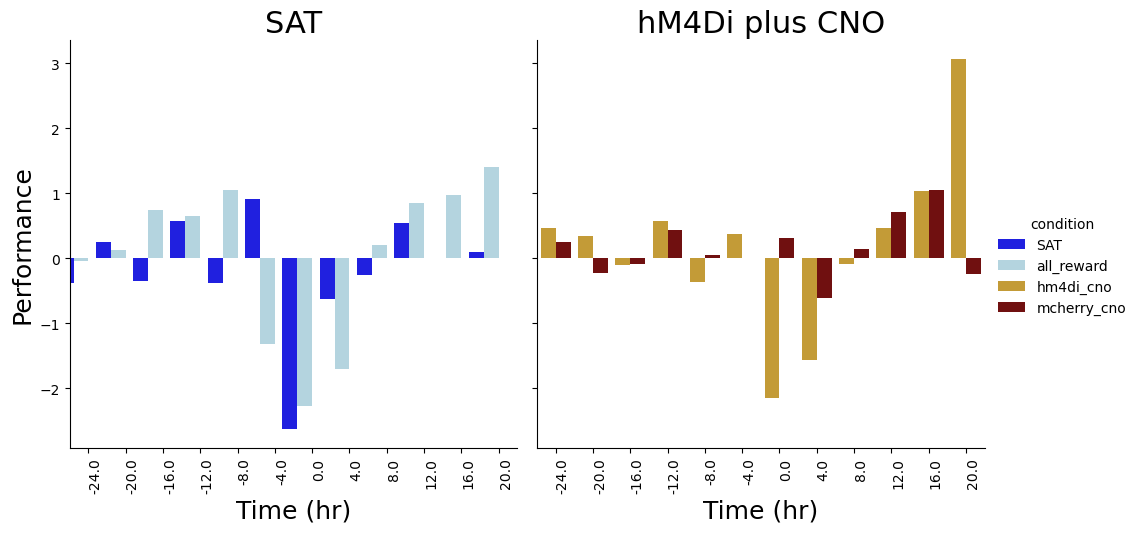

In [180]:
# anticipatory licking by previous trial contingency
ant = perf[(perf["Time (ms)"] == 900) & (perf["condition"] != "dcz_05")] 
cond = (ant["Time (hr)"] < 24) & (ant["Time (hr)"] >= -24)

g = sns.catplot(ant[cond], x="Time (hr)", y="lick",
                hue="condition", col ="type", palette = ["blue", "lightblue", "goldenrod", "maroon"], 
                kind="bar", errorbar=None)

cond_dict = {"sat":"SAT", "all_reward":"100% acclimation, 80% SAT", "hm4di":"hM4Di plus CNO", "mcherry_cno":"mCherry plus CNO"}
for (col_val), ax in g.axes_dict.items():
    t=f"{cond_dict[col_val]}"
    ax.set_title(t, fontsize=22)
    #ax.tick_params(labelbottom=True, labelsize=18)
    ax.set_xticklabels(ax.get_xticklabels(), rotation=90, ha="right", rotation_mode="anchor")
    ax.set_ylabel("Performance", fontsize=18)
    ax.set_xlabel("Time (hr)", fontsize=18)
    new_value=0.4
    i = 0
    for patch in ax.patches:
            current_width = patch.get_width()
            diff = current_width - new_value

            # we change the bar width
            patch.set_width(new_value)
            # we recenter the bar
            if ((i<len(ax.patches)/4) | ((i>=len(ax.patches)/2) & (i<3*len(ax.patches)/4))):
                move =  diff*0.5  
            else:
                move = diff*-0.5
            patch.set_x(patch.get_x() + move - 0.3) 
            i +=1   
g.figure.subplots_adjust(hspace=0.3)



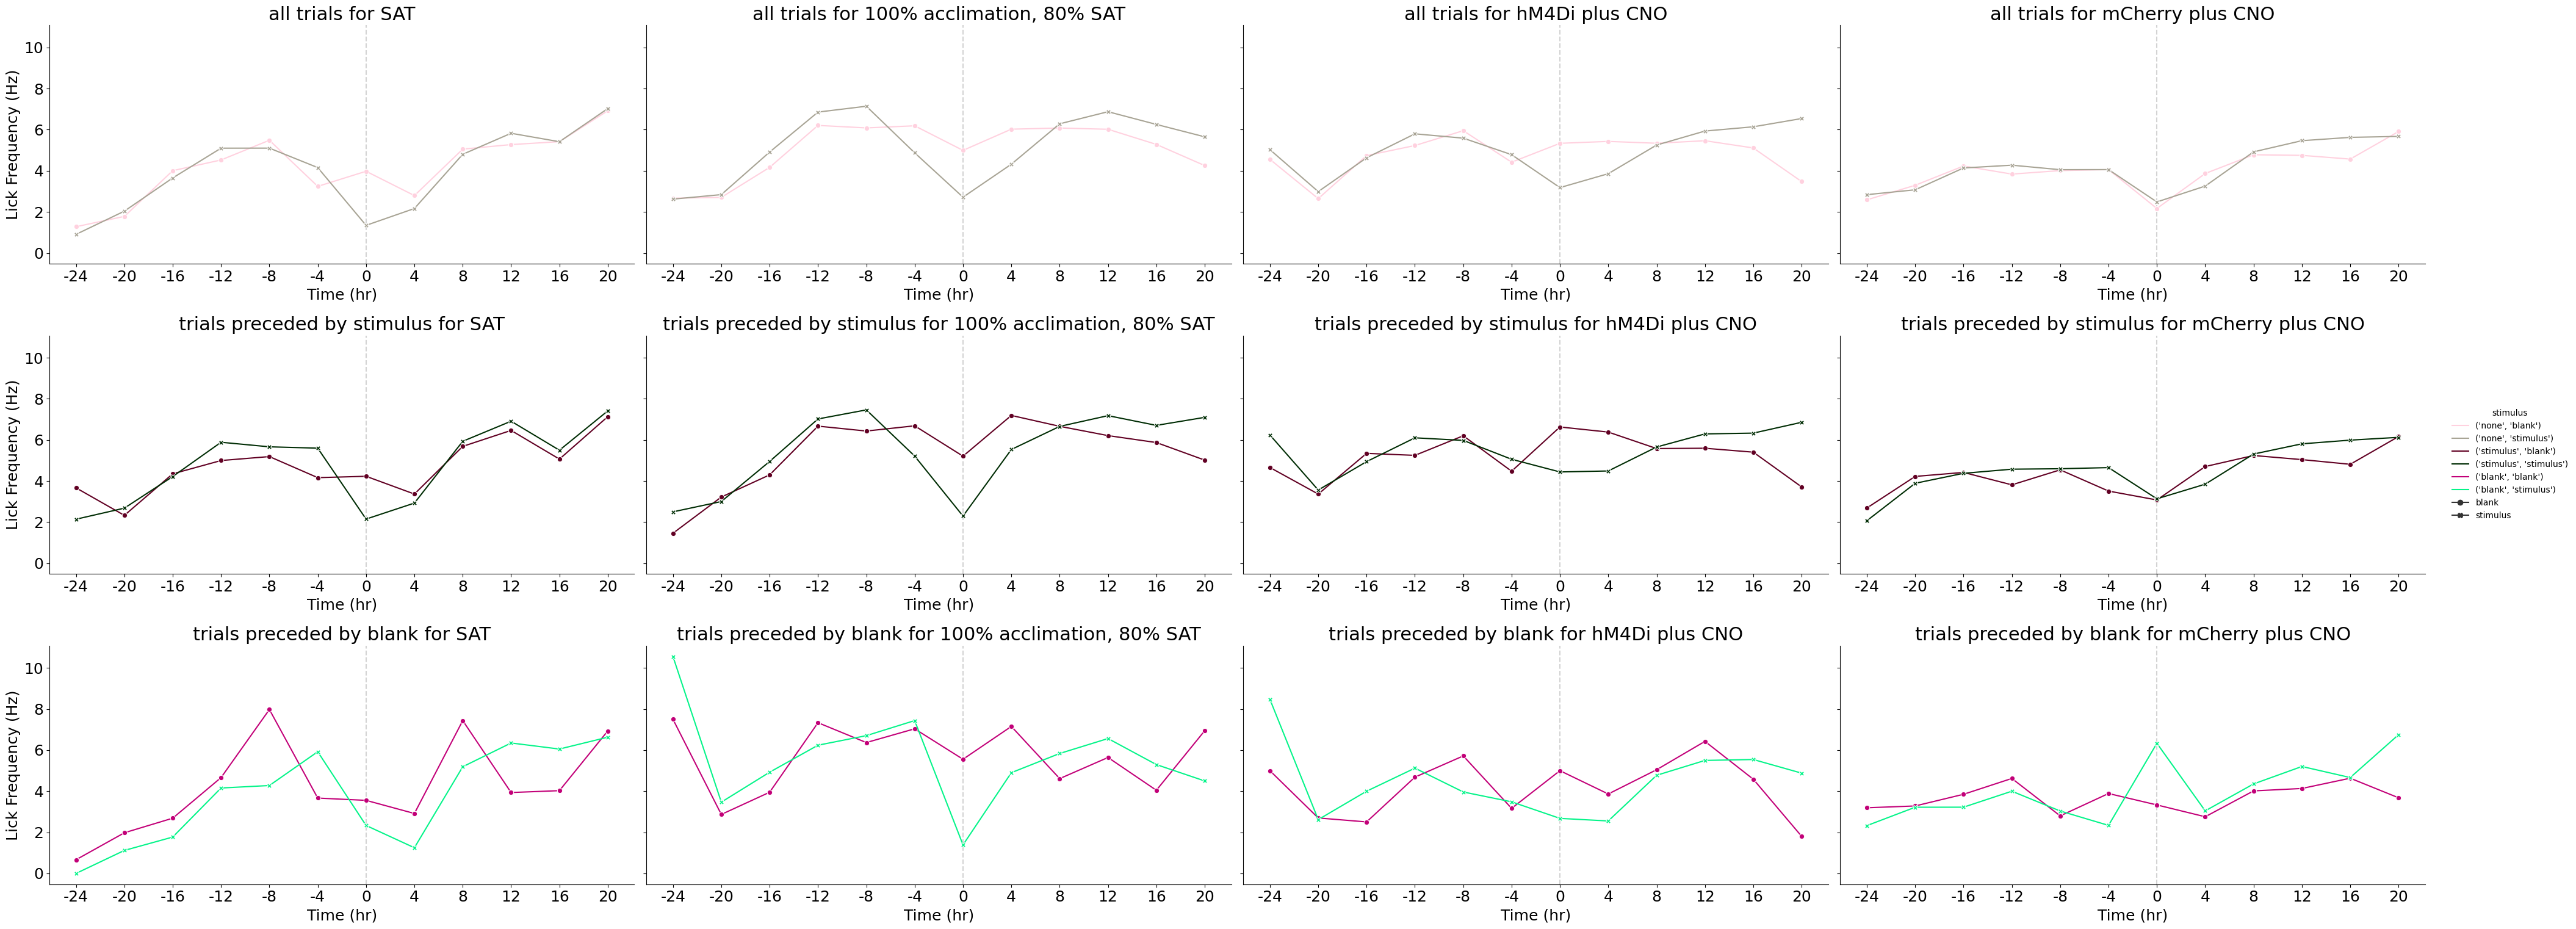

In [ ]:
# anticipatory licking by previous trial contingency
ant = mean_statistics[(mean_statistics["Time (ms)"] == 900) & (mean_statistics["condition"] != "dcz_05")] 
cond = (ant["Time (hr)"] < 24) & (ant["Time (hr)"] >= -24) & (ant["n_back"] < 2)

h = ant[cond][['back_type', 'stimulus']].apply(tuple, axis=1)
p = ["xkcd:light pink", "xkcd:greyish", "xkcd:burgundy", "xkcd:dark forest green", "xkcd:magenta", "xkcd:turquoise green"]
ordr = [('none', 'blank'), ('none', 'stimulus'), ('stimulus', 'blank'),
       ('stimulus', 'stimulus'), ('blank', 'blank'),
       ('blank', 'stimulus')]

g = sns.relplot(ant[cond], x="Time (hr)", y="lick", 
                hue=h, col ="condition", row="back_type", palette = p, 
                hue_order=ordr, kind="line", errorbar=None, style="stimulus", 
                dashes=False, markers=True, aspect=2, facet_kws={"sharex":False})

row_dict = {"none":"all trials", "stimulus":"trials preceded by stimulus", "blank":"trials preceded by blank"}
col_dict = {"SAT":"SAT", "all_reward":"100% acclimation, 80% SAT", "hm4di_cno":"hM4Di plus CNO", "mcherry_cno":"mCherry plus CNO"}


ticks = [i for i in range(-24, 24, 4)]
for (row_val, col_val), ax in g.axes_dict.items():
    t = f'{row_dict[row_val]} for {col_dict[col_val]}'
    ax.set_title(t, fontsize=22)
    ax.axvline(x=0, ymin=0, ymax=1, ls="--", color="lightgrey", zorder=0)
    ax.set_xticks(ticks)
    ax.set_xticklabels(ticks, ha='center')
    ax.tick_params(labelbottom=True, labelsize=18)
    ax.set_ylabel("Lick Frequency (Hz)", fontsize=18)
    ax.set_xlabel("Time (hr)", fontsize=18)
g.figure.subplots_adjust(hspace=0.3)

[None, None, None, None, None, None, None, None]

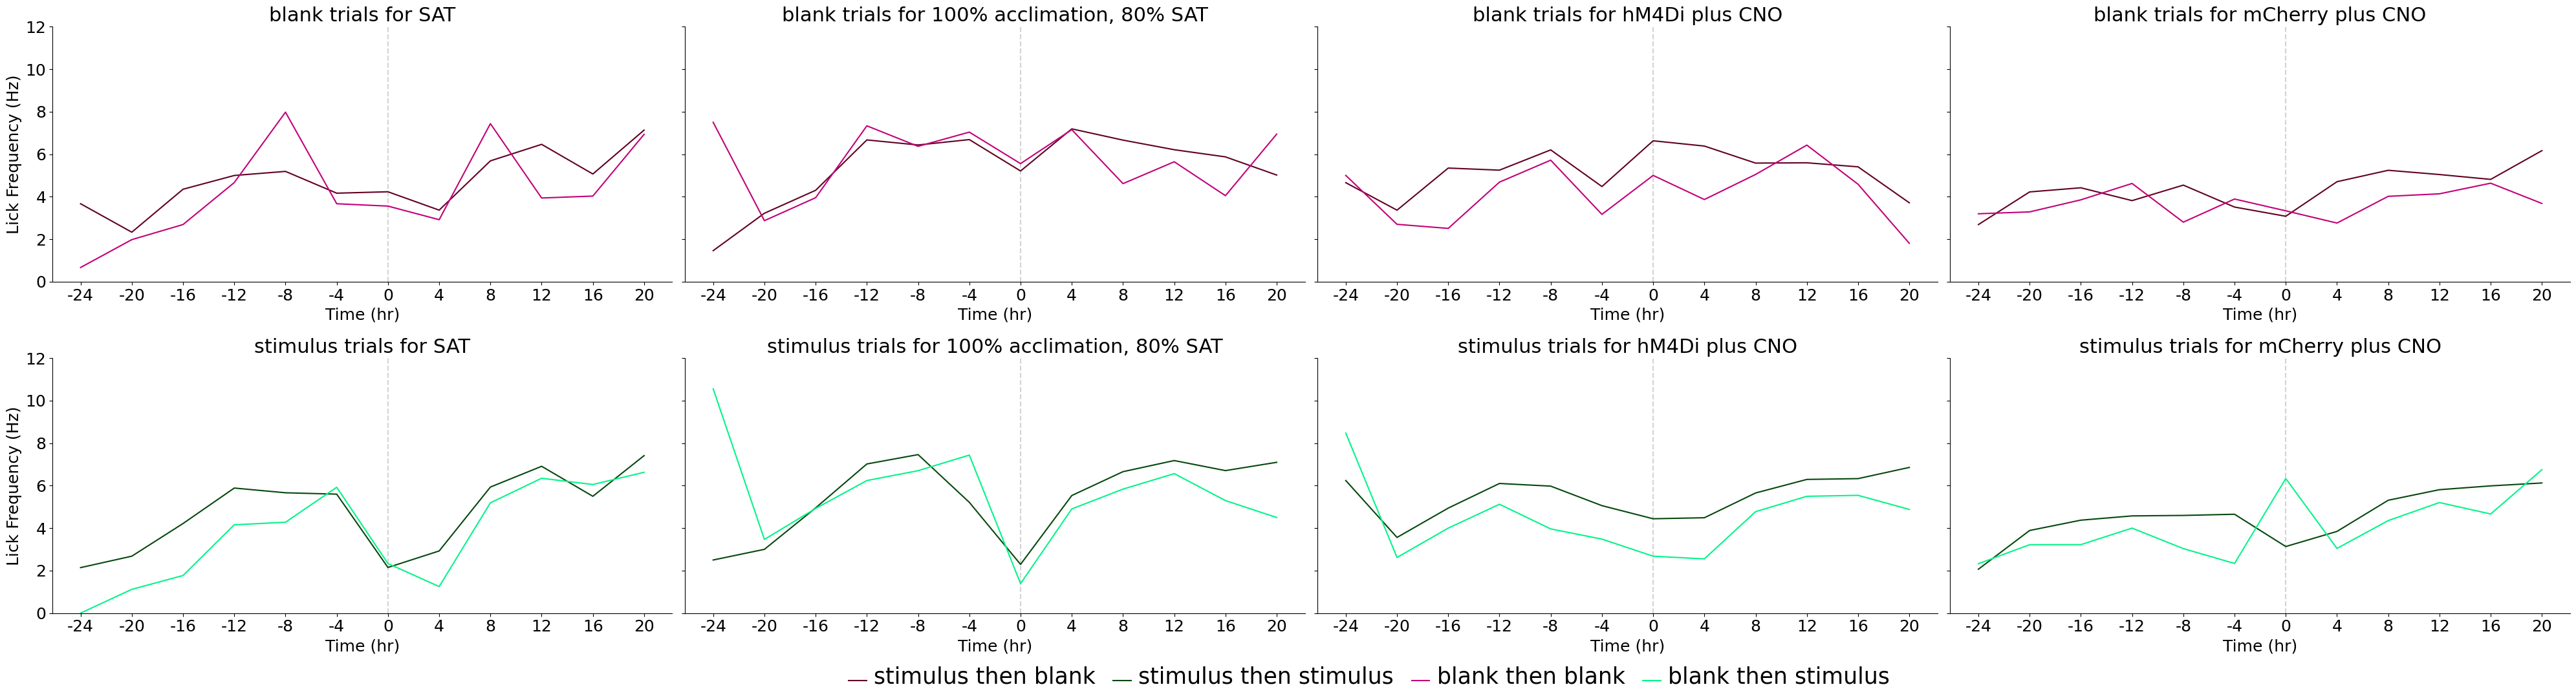

In [ ]:
# anticipstory licking by previous trial contingency blank vs blank and stim vs stim
p = ["xkcd:burgundy", "xkcd:british racing green", "xkcd:magenta", "xkcd:turquoise green"]
ordr = [('stimulus', 'blank'),
       ('stimulus', 'stimulus'), ('blank', 'blank'),
       ('blank', 'stimulus')]
cond = (ant["Time (hr)"] < 24) & (ant["Time (hr)"] >= -24) & (ant["n_back"] < 2) & (ant["back_type"] != "none")

h = ant[cond][['back_type', 'stimulus']].apply(tuple, axis=1)
g = sns.relplot(ant[cond], x="Time (hr)", y="lick", 
                hue=h, col ="condition", row="stimulus", palette = p, 
                hue_order=ordr, kind="line", errorbar=None, aspect=2, facet_kws={"sharex":False})

row_dict = {"stimulus":"stimulus trials", "blank":"blank trials"}
col_dict = {"SAT":"SAT", "all_reward":"100% acclimation, 80% SAT", "hm4di_cno":"hM4Di plus CNO", "mcherry_cno":"mCherry plus CNO"}


ticks = [i for i in range(-24, 24, 4)]
for (row_val, col_val), ax in g.axes_dict.items():
    t = f'{row_dict[row_val]} for {col_dict[col_val]}'
    ax.set_title(t, fontsize=22)
    ax.axvline(x=0, ymin=0, ymax=1, ls="--", color="lightgrey", zorder=0)
    ax.set_xticks(ticks)
    ax.set_xticklabels(ticks, ha='center')
    ax.tick_params(labelbottom=True, labelsize=18)
    ax.set_ylabel("Lick Frequency (Hz)", fontsize=18)
    ax.axes.xaxis.set_visible(True)
    ax.set_xlabel("Time (hr)", fontsize=18)
    ax.set_ylim([0, 12])
new_texts = {"('stimulus', 'blank')":"stimulus then blank",
       "('stimulus', 'stimulus')":"stimulus then stimulus", "('blank', 'blank')":"blank then blank",
       "('blank', 'stimulus')":"blank then stimulus"}
#g._legend.set_title("Previous and Current Trial Type")

for t in g._legend.get_texts():
    t.set_text(new_texts[t.get_text()])

g.figure.subplots_adjust(hspace=0.3)
sns.move_legend(g, "lower center", ncol=5, bbox_to_anchor=(0.5,-0.07),title=None)
#plt.setp(g._legend.get_title(), fontsize='20')
plt.setp(g._legend.get_texts(), fontsize='25')



#### Output Results 

In [221]:
# TODO: output raw data
# TODO: output parameters as metadata 
analysis_directory = 'C:\\Users\\swind\\Documents\\lab_work\\Barth\\behavior_analysis\\Eunsol_data\\refactor_4h'


output_dir = f'{analysis_directory}/all_conditions'

cols = ["condition", "animal", "stimulus", "Time (hr)", "Time (ms)", "lick"]
mean_statistics.to_excel(f'{output_dir}_lick_frequency.xlsx', columns=cols, index=False)

cols = ["condition", "animal", "Time (hr)", "stimulus", "trial no"]
counts.to_excel(f'{output_dir}_trial_counts.xlsx', columns=cols, index=False)

cols = ["condition", "animal", "Time (hr)", "Time (ms)", "lick"]
perf.to_excel(f'{output_dir}_performance.xlsx', columns=cols, index=False)


# full data has too many lines to output to excel with all four conditions
# takes like 1m 30s to output to csv
data.to_csv(f'{output_dir}_lickfrequency.csv', index=False)

#### Pipeline description

__Pipeline:__

>```
>raw data (csv) ------------|    loader.py                                                     lickfreq_analysis                                            
>                            |------------------> formatted data - many animals (dataframe) ---------------------------> trial-level analysis(dataframe)
>metadata (excel) ----------|
>
>                                     aggregate_analysis   |---> trial number counts by timebin and condition (dataframe) ---|
>trial-level analysis (dataframe) ------------------------|---> mean lick frequency by timebin (dataframe) -----------------|---> plots
>                                                          |---> performance by timebin (dataframe) -------------------------|
>```

***

__Formats__

*raw data*

>time (ms), poke, lick, condition code, delay, stimulus

- time measured from start of file
- poke in {0, 1}
- lick in {0, 2}
- condition code in {3, 4, 5, 7, 9}
    - 3 = delay
    - 4 = air delivery
    - 5 = water delivery
    - 7 = after water delivery
    - 9 = blank
- 200 <= delay <= 800
- stimulus in {0, 1}
    - stimulus not present in SAT code
    - stimulus present and relevant in pseudo code

*metadata*

- excel
- must include 'Animal ID' (3 letter + number animal code)
- must include 'acc' (time of acclimation in days)
- other example columns: age, sex, strain

*formatted data*

>timestamp, poke, lick, condition code, delay, trial no, water, stimulus, animal, condition, metadata

- metadata can be multiple columns

*trial-level analysis*
> condition, animal, trial no, puff delta, trial start, timestamp, metadata, stimulus, water, lick, poke, delta, time (hr), time (ms)

- puff delta is equivalent to time (ms)
    - represents timestamp normalized to air delivery
    - puff delta is timedelta and time (ms) is float
- trial start represents timebin as timestamp
- delta is equivalent to time (hr)
    - represents timebin normalized to start of stat
    - delta is timedelta and time (hr) is float
- metadata can be multiple columns
- lick and poke now represent frequencys aggregated based on given window size

